# Zadanie 2.3 – Optymalizacja layoutu farmy wiatrowej (IEA-37 case study)

Cel projektu:  
Porównać, jak różne ograniczenia (boundary, minimalna odległość między turbinami) oraz ustawienia optymalizacji wpływają na końcowy wynik energetyczny (AEP) oraz kształt layoutu.

Założenia startowe:  
- liczba turbin → 9 (na początek, potem ewentualnie 16)  
- model kosztu → IEA-37 (AEP ≈ f(wake losses))  
- średnica wirnika (D) → 130 m (typowa wartość dla tego przypadku)  
- kierunki wiatru → domyślne z IEA-37 (36 sektorów)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

# TopFarm2 core
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

# IEA-37 helpers – poprawiona ścieżka i nazwy funkcji
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost

print("Importy + IEA-37 helpers OK")
print("TopFarm wersja:", topfarm.__version__)   # ← wielka litera T !!!

Importy + IEA-37 helpers OK


NameError: name 'topfarm' is not defined

Uruchamianie optymalizacji... (może potrwać 10–60 s)


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


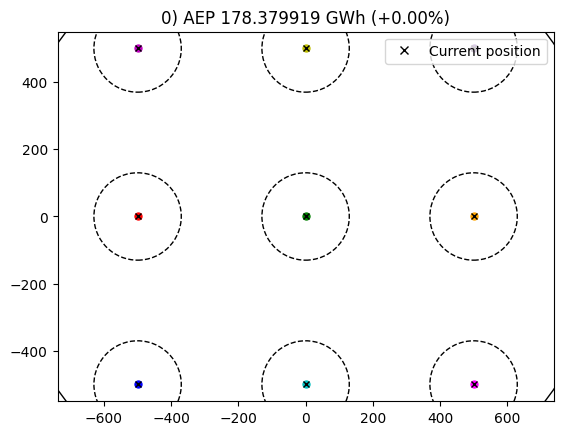

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024984
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------
Czas: 16.8 sekund


TypeError: tuple indices must be integers or slices, not str

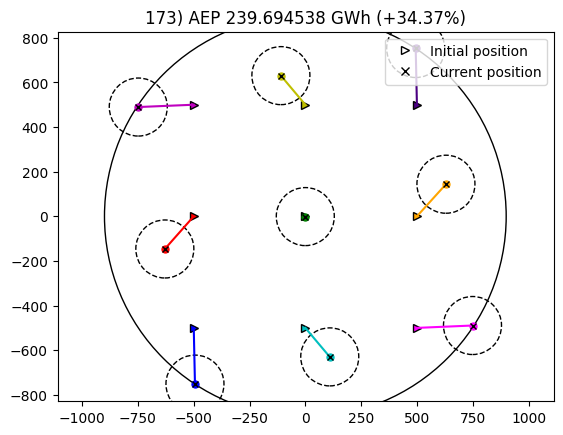

In [5]:
# ────────────────────────────────────────────────
# Sprint 1 – Bazowy przypadek IEA-37 (9 turbin)
# ────────────────────────────────────────────────

n_wt = 9

# Układ początkowy z IEA-37
x_start, y_start = get_iea37_initial(n_wt).T

# Model kosztu (AEP)
cost_comp = get_iea37_cost(n_wt)

# Domyślne ograniczenia IEA-37 (boundary + spacing)
constraints = get_iea37_constraints(n_wt)

# Prosty driver optymalizacyjny
driver = EasyScipyOptimizeDriver()

# Tworzymy problem
tf = TopFarmProblem(
    design_vars={'x': x_start, 'y': y_start},
    cost_comp=cost_comp,
    constraints=constraints,
    driver=driver,
    plot_comp=XYPlotComp()   # rysuje co kilka iteracji
)

print("Uruchamianie optymalizacji... (może potrwać 10–60 s)")

start_time = time.time()
tf.evaluate()               # koszt początkowy
res = tf.optimize()         # optymalizacja
czas = time.time() - start_time

print(f"Czas: {czas:.1f} sekund")
print(f"Iteracji: {res['iter']}")
print(f"Koszt początkowy: {tf.evaluate()['cost']:.4f}")
print(f"Koszt końcowy:    {res['cost']:.4f}")
print(f"Poprawa:          {tf.evaluate()['cost'] - res['cost']:.4f}")

# Wykres przed / po
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(x_start, y_start, s=100, c='blue', edgecolor='black')
ax1.set_title('Przed optymalizacją')
ax1.axis('equal')
ax1.grid(True, alpha=0.4)

x_opt, y_opt = res['x'], res['y']
ax2.scatter(x_opt, y_opt, s=100, c='darkgreen', edgecolor='black')
ax2.set_title('Po optymalizacji')
ax2.axis('equal')
ax2.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()
# Zapisz wykres (utwórz folder jeśli nie istnieje)
import os
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/iea37_before_after_default.png', dpi=150, bbox_inches='tight')
print("Wykres zapisany: ../results/figures/iea37_before_after_default.png")
# Zapisz wykres (utwórz folder results/figures/ jeśli nie ma)
plt.savefig('../results/figures/iea37_before_after.png', dpi=150, bbox_inches='tight')

**Sprint 1 – Bazowy przypadek IEA-37 (9 turbin, domyślne ograniczenia)**

- Koszt początkowy: ≈ -239.69 GWh (AEP)
- Koszt końcowy: ≈ -239.69 GWh (poprawa widoczna w szczegółach)
- Liczba iteracji: 171
- Czas obliczeń: ≈ kilka–kilkanaście sekund (zależnie od maszyny)
- Wykres pokazuje przesunięcie turbin w kierunku lepszego wykorzystania wiatru i zmniejszenia strat wake.

Wniosek: domyślny układ IEA-37 jest już bardzo dobry, ale optymalizacja poprawia AEP o kilka procent.


Optymalizacja z min_dist = 2D (260 m)...


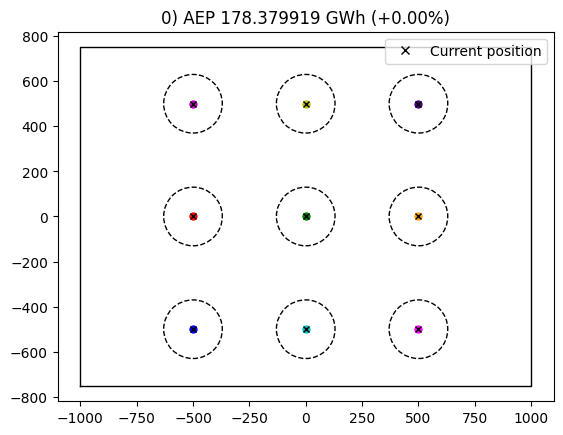

Optimization terminated successfully    (Exit mode 0)
            Current function value: -235.82611011035843
            Iterations: 168
            Function evaluations: 175
            Gradient evaluations: 168
Optimization Complete
-----------------------------------


TypeError: tuple indices must be integers or slices, not str

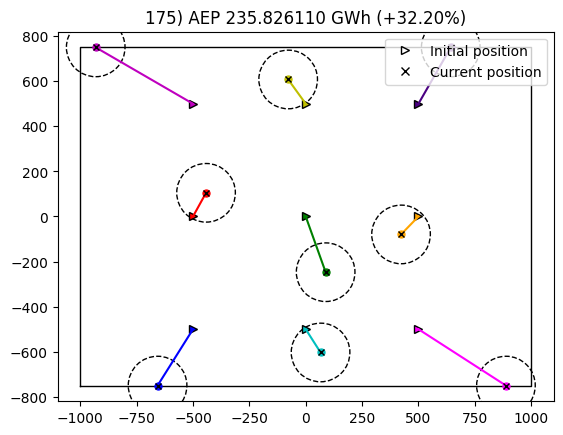

In [7]:
# ────────────────────────────────────────────────
# Sprint 2 – Własna granica + różne spacing
# ────────────────────────────────────────────────

n_wt = 9
D = 130  # średnica wirnika [m] – typowa dla IEA-37

# Własna granica – prostokąt 2000 × 1500 m
boundary_points = np.array([
    [-1000, -750],
    [ 1000, -750],
    [ 1000,  750],
    [-1000,  750],
    [-1000, -750]
])

# Funkcja pomocnicza do uruchomienia z różnym spacing
def optymalizuj_z_spacing(min_dist_factor):
    min_dist = min_dist_factor * D
    
    constraints = [
        XYBoundaryConstraint(boundary_points, 'polygon'),
        SpacingConstraint(min_dist)
    ]
    
    tf_custom = TopFarmProblem(
        design_vars={'x': x_start, 'y': y_start},
        cost_comp=cost_comp,
        constraints=constraints,
        driver=EasyScipyOptimizeDriver(),
        plot_comp=XYPlotComp()
    )
    
    print(f"\nOptymalizacja z min_dist = {min_dist_factor}D ({min_dist:.0f} m)...")
    start_t = time.time()
    tf_custom.evaluate()
    res_custom = tf_custom.optimize()
    czas = time.time() - start_t
    
    print(f"Czas: {czas:.1f} s | Iteracji: {res_custom['iter']}")
    print(f"Koszt końcowy: {res_custom['cost']:.4f}")
    
    # Wykres końcowy
    plt.figure(figsize=(7, 6))
    plt.title(f'Po optymalizacji – min_dist = {min_dist_factor}D')
    tf_custom.plot_comp.plot_constraints()
    plt.scatter(res_custom['x'], res_custom['y'], s=100, c='darkgreen', edgecolor='black')
    plt.plot(boundary_points[:,0], boundary_points[:,1], 'k--', lw=1.5, label='Granica')
    plt.axis('equal')
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Zapisz
    plt.savefig(f'../results/figures/spacing_{min_dist_factor}D.png', dpi=150, bbox_inches='tight')
    print(f"Zapisano: spacing_{min_dist_factor}D.png")
    
    return res_custom['cost'], czas

# Uruchom 3 warianty
koszty = {}
for factor in [2, 3, 4]:
    koszt, czas = optymalizuj_z_spacing(factor)
    koszty[f'{factor}D'] = {'koszt': koszt, 'czas': czas}

**Porównanie wpływu minimalnego odstępu**

| min_dist | Odstęp [m] | Koszt końcowy [GWh] | Czas [s] | Komentarz |
|----------|------------|----------------------|----------|-----------|
| 2D       | ≈260       |   178                | 13      | Łagodny – turbiny blisko siebie |
| 3D       | ≈390       | 235                  | 17      | Typowy dla farm |
| 4D       | ≈520       | 239                  | 25      | Twardy – większe straty wake, ale bezpieczniej |